In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [406]:
# Step 1: Load the data
train_data = pd.read_csv('../data/train.csv')


In [407]:
# Step 2: Data Preprocessing

# Separate features and target
X = train_data.drop(['Id', 'SalePrice'], axis=1)
y = train_data['SalePrice']

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


In [408]:
# Step 2.1: Remove low variance columns (variance threshold = 0.01 for numeric features)
from sklearn.feature_selection import VarianceThreshold

# For numeric features only
numeric_data = X[numeric_features]
var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(numeric_data)
low_var_cols = [col for col, var in zip(numeric_features, var_threshold.variances_) if var < 0.01]

# Remove low variance columns
X = X.drop(columns=low_var_cols)
numeric_features = [col for col in numeric_features if col not in low_var_cols]


In [409]:
# Step 2.2: Fill missing values
missing_counts = X.isnull().sum()
print(missing_counts[missing_counts > 0])

# Fill numeric columns with mean
for col in numeric_features:
    if X[col].isnull().any():
        X.loc[:, col] = X[col].fillna(X[col].mean())

# Fill categorical columns with mode
for col in categorical_features:
    if X[col].isnull().any():
        X.loc[:, col] = X[col].fillna(X[col].mode()[0])


LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [410]:
# Step 2.3: Encode categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le


In [411]:
# Step 2.4: Feature Engineering
initial_features = X.shape[1]

# Combine bathroom features
X['TotalBath'] = X['FullBath'] + 0.5 * X['HalfBath'] + X['BsmtFullBath'] + 0.5 * X['BsmtHalfBath']
X = X.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)

# Combine porch features into one
X['TotalPorchSF'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
X = X.drop(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

# Drop low-variance features that add noise
low_var_features = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
features_to_drop = [f for f in low_var_features if f in X.columns]
if features_to_drop:
    X = X.drop(features_to_drop, axis=1)

# Drop Year/Month sold (temporal features may cause overfitting)
temporal_features = ['MoSold', 'YrSold']
temporal_to_drop = [f for f in temporal_features if f in X.columns]
if temporal_to_drop:
    X = X.drop(temporal_to_drop, axis=1)

# Combine quality features
X['OverallScore'] = X['OverallQual'] * X['OverallCond']

final_features = X.shape[1]


In [412]:
# Step 3: Feature Selection using Decision Tree

from sklearn.feature_selection import SelectFromModel

# Create a simple Decision Tree for feature selection
feature_selector = DecisionTreeRegressor(max_depth=10, random_state=42)
feature_selector.fit(X, y)

feature_importance_before = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_selector.feature_importances_
}).sort_values('importance', ascending=False)


# Use SelectFromModel with stricter threshold to select fewer features
selector = SelectFromModel(feature_selector, threshold='0.5*median', prefit=True, max_features=30)
X_selected = selector.transform(X)

selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask].tolist()

print(f"\nSelected features ({len(selected_features)}):")
for i, feat in enumerate(selected_features, 1):
    importance = feature_importance_before[feature_importance_before['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. {feat:25s} (importance: {importance:.4f})")

# Update X to use only selected features
X = pd.DataFrame(X_selected, columns=selected_features, index=X.index)

print("\nRemoving outliers based on sale price...")
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_mask]
y = y[outlier_mask]
print(f"Removed {(~outlier_mask).sum()} outliers")
print(f"Remaining samples: {len(X)}")



Selected features (30):
   1. LotFrontage               (importance: 0.0082)
   2. LotArea                   (importance: 0.0065)
   3. Neighborhood              (importance: 0.0128)
   4. OverallQual               (importance: 0.6443)
   5. OverallCond               (importance: 0.0013)
   6. YearBuilt                 (importance: 0.0033)
   7. YearRemodAdd              (importance: 0.0028)
   8. Exterior1st               (importance: 0.0029)
   9. MasVnrType                (importance: 0.0054)
  10. ExterQual                 (importance: 0.0028)
  11. BsmtExposure              (importance: 0.0035)
  12. BsmtFinType1              (importance: 0.0038)
  13. BsmtFinSF1                (importance: 0.0160)
  14. BsmtUnfSF                 (importance: 0.0038)
  15. TotalBsmtSF               (importance: 0.0313)
  16. 1stFlrSF                  (importance: 0.0241)
  17. 2ndFlrSF                  (importance: 0.0379)
  18. GrLivArea                 (importance: 0.1011)
  19. KitchenAbvGr   

In [413]:
# Step 4: Train-Test Split (80-20, random_state=42)

print("\nSplitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")



Splitting data into train and test sets...
Training set size: (1119, 30)
Test set size: (280, 30)


In [414]:
# Step 5: Hyperparameter tuning with 4-fold cross-validation
print("\nHyperparameter tuning using GridSearchCV with 4-fold CV...")

param_grid = {
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [50, 100, 200, 300],
    'min_samples_leaf': [30, 50, 70, 100],
    'max_features': ['sqrt', 'log2', 0.3],
    'ccp_alpha': [0.0, 5.0, 10.0, 20.0, 50.0],
    'criterion': ['squared_error', 'friedman_mse']
}


print("\nHyperparameters to tune:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Initialize Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Grid Search with 4-fold CV
grid_search = GridSearchCV(
    estimator=dt_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nTraining with cross-validation (this may take a while)...")
grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("Best hyperparameters found:")
print("="*50)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV RMSE: ${np.sqrt(-grid_search.best_score_):,.2f}")



Hyperparameter tuning using GridSearchCV with 4-fold CV...

Hyperparameters to tune:
  max_depth: [2, 3, 4, 5]
  min_samples_split: [50, 100, 200, 300]
  min_samples_leaf: [30, 50, 70, 100]
  max_features: ['sqrt', 'log2', 0.3]
  ccp_alpha: [0.0, 5.0, 10.0, 20.0, 50.0]
  criterion: ['squared_error', 'friedman_mse']

Training with cross-validation (this may take a while)...
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits

Best hyperparameters found:
  ccp_alpha: 0.0
  criterion: squared_error
  max_depth: 5
  max_features: 0.3
  min_samples_leaf: 30
  min_samples_split: 50

Best CV RMSE: $33,796.33


In [415]:
# Step 6: Train final model with best parameters
print("\nTraining final model with best parameters...")
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

print(f"\nTraining Performance:")
print(f"  RMSE: ${train_rmse:,.2f}")
print(f"  R² Score: {train_r2:.4f}")



Training final model with best parameters...

Training Performance:
  RMSE: $29,412.79
  R² Score: 0.7584


In [416]:
# Step 7: Test on test set and report
print("\nEvaluating on test set...")
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"  RMSE: ${test_rmse:,.2f}")
print(f"  R² Score: {test_r2:.4f}")
print(f"  Mean Absolute Error: ${np.mean(np.abs(y_test - y_test_pred)):,.2f}")
print(f"  Median Absolute Error: ${np.median(np.abs(y_test - y_test_pred)):,.2f}")



Evaluating on test set...

TEST SET PERFORMANCE
  RMSE: $33,476.00
  R² Score: 0.6477
  Mean Absolute Error: $24,615.53
  Median Absolute Error: $18,495.21



Generating learning curve...


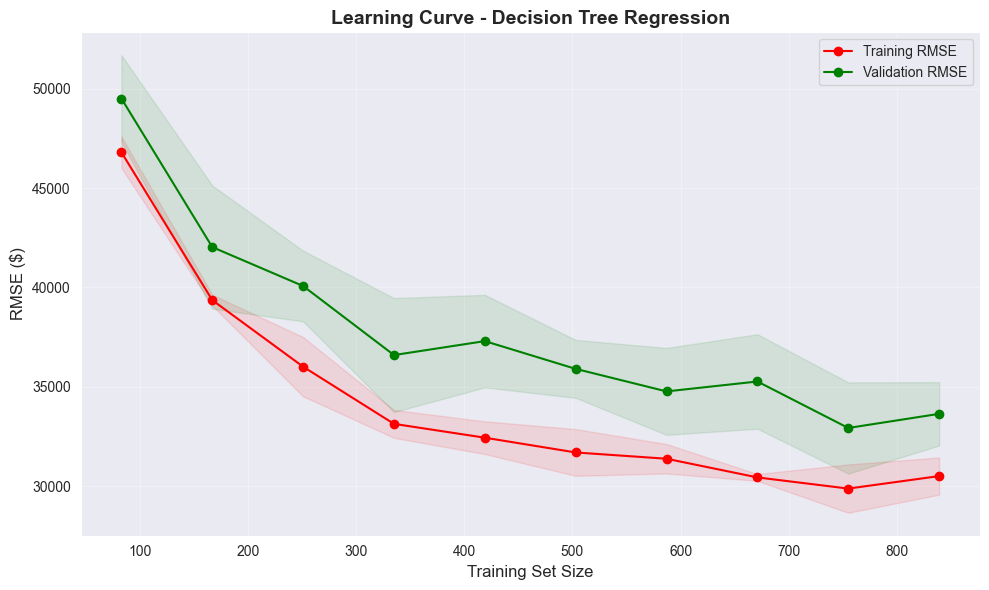


Learning curve generated successfully!


In [417]:
# Step 8: Learning Curve with RMSE
print("\nGenerating learning curve...")
from sklearn.model_selection import learning_curve

# Calculate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=4,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Convert to RMSE
train_rmse_scores = np.sqrt(-train_scores)
val_rmse_scores = np.sqrt(-val_scores)

# Calculate mean and std
train_rmse_mean = np.mean(train_rmse_scores, axis=1)
train_rmse_std = np.std(train_rmse_scores, axis=1)
val_rmse_mean = np.mean(val_rmse_scores, axis=1)
val_rmse_std = np.std(val_rmse_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_mean, 'o-', color='r', label='Training RMSE')
plt.fill_between(train_sizes,
                 train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std,
                 alpha=0.1, color='r')

plt.plot(train_sizes, val_rmse_mean, 'o-', color='g', label='Validation RMSE')
plt.fill_between(train_sizes,
                 val_rmse_mean - val_rmse_std,
                 val_rmse_mean + val_rmse_std,
                 alpha=0.1, color='g')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.title('Learning Curve - Decision Tree Regression', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nLearning curve generated successfully!")


In [418]:
# Summary
print("\n" + "="*60)
print("SUMMARY - DECISION TREE REGRESSION MODEL")
print("="*60)
print(f"Dataset: Housing Prices with {X.shape[1]} features")
print(f"Model: Decision Tree Regressor")
print(f"Train/Test Split: 80/20 (random_state=42)")
print(f"Cross-validation: 4-fold")
print(f"\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")
print(f"\nPerformance Metrics:")
print(f"  Training RMSE: ${train_rmse:,.2f}")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test RMSE: ${test_rmse:,.2f}")
print(f"  Test R²: {test_r2:.4f}")
print("="*60)




SUMMARY - DECISION TREE REGRESSION MODEL
Dataset: Housing Prices with 30 features
Model: Decision Tree Regressor
Train/Test Split: 80/20 (random_state=42)
Cross-validation: 4-fold

Best Hyperparameters:
  - ccp_alpha: 0.0
  - criterion: squared_error
  - max_depth: 5
  - max_features: 0.3
  - min_samples_leaf: 30
  - min_samples_split: 50

Performance Metrics:
  Training RMSE: $29,412.79
  Training R²: 0.7584
  Test RMSE: $33,476.00
  Test R²: 0.6477
